## Can 2nd Loan Repayment be Predicted from 1st?
### Examine joint distributions of possible features

In [1]:
# import relevant modules
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import math
import datetime as dt
from scipy import stats


/Users/JoleneMork/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# Import data about all the loans
loan_data = pd.read_csv('~/quieries_20160922/Loans_numericInfo_firstTwoInstallments.csv')

In [4]:
# Import data about all the labels
loans_late6mo = pd.read_csv('/Users/JoleneMork/Documents/Insight_Data_Science/quieries_20160922/LoansBorrowers_Late6mo.csv')
loans_ontime6mo = pd.read_csv('/Users/JoleneMork/Documents/Insight_Data_Science/quieries_20160922/LoansBorrowers_OnTime6mo.csv')
loans_repaid6mo = pd.read_csv('/Users/JoleneMork/Documents/Insight_Data_Science/quieries_20160922/LoansBorrowers_repaid6mo.csv')

In [5]:
# Set labels which correspond to whether the loan was late or on-time at 6 months

loans_late6mo['late'] = 1
loans_ontime6mo['late'] = 0
allLoans = loans_ontime6mo.append(loans_late6mo)
loans_repaid6mo['late'] = 0
allLoans = allLoans.append(loans_repaid6mo)
allLoans.head()

,loan_id,borrower_id,late
0,4671,3524,0
1,4751,4034,0
2,4756,1754,0
3,4777,4871,0
4,4782,14656,0


In [6]:
# drop loans without borrower id
allLoans_noBorrower = allLoans.drop('borrower_id',1)

In [7]:
# Convert disbursed_at, paid_date, and due_date to datetime objects, only keep year, month, day

def convert_to_dt(string):
    try:
        dateobj = dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
        return dateobj.date()
    except:
        pass

loan_data.applied_at = loan_data.applied_at.apply(convert_to_dt)
loan_data.head(3)

,loan_id,borrower_id,time_diff,usd_amount,lender_interest_rate,time_app_disb,appl_month,disb_month,applied_at,currency_code
0,4737,14745,-21,50,2.63,32,12,1,2013-12-20,KES
1,4737,14745,-28,50,2.63,32,12,1,2013-12-20,KES
2,4741,12061,-13,50,5.12,32,12,1,2013-12-20,KES


In [8]:
# Want to correlate borrowers in loans in two dictionaries

borrowers_loans = loan_data[['loan_id', 'borrower_id']]

unique_loan_ids = list(borrowers_loans.loan_id.unique())

loans = {}
borrowers = {}
for index, loan_id, borrower_id in borrowers_loans.itertuples():
    if loan_id not in loans:
        loans[loan_id] = borrower_id
        if borrower_id not in borrowers:
            borrowers[borrower_id] = [loan_id]
        else:
            borrowers[borrower_id].append(loan_id)

In [9]:
# Make separate dataframes for single loan borrowers (slb), 
# and the first (fl), second (sl), and third loans (tl) of multi-loan borrowers
        
slb = pd.DataFrame()
mlb_fl = pd.DataFrame()
mlb_sl = pd.DataFrame()
mlb_tl = pd.DataFrame()

for keys, vals in borrowers.iteritems():
    if len(vals) == 1:
        slb = slb.append(loan_data[loan_data.loan_id == vals])
    elif len(vals) > 1:
        fl = vals[0] # the first item for a given borrower id = the first loan
        sl = vals[1] # the second item is the second loans
        mlb_fl = mlb_fl.append(loan_data[loan_data.loan_id == fl])
        mlb_sl = mlb_sl.append(loan_data[loan_data.loan_id == sl])
        try:
            tl = vals[2] # the third item is the third loan_id
            mlb_tl = mlb_tl.append(loan_data[loan_data.loan_id == tl])
        except:
            continue

In [10]:
# Now merge the allLoans df with mlbfl and mlbsl in order to get correct labels for whether the loan was late at 6 months
slb_labeled = pd.merge(slb, allLoans_noBorrower, how = 'left', on = 'loan_id')
mlbfl_labeled = pd.merge(mlb_fl, allLoans_noBorrower, how = 'left', on = 'loan_id')
mlbsl_labeled = pd.merge(mlb_sl, allLoans_noBorrower, how = 'left', on = 'loan_id')
mlbtl_labeled = pd.merge(mlb_tl, allLoans_noBorrower, how = 'left', on = 'loan_id')

In [11]:
mlbfl_labeled.head(2)

,loan_id,borrower_id,time_diff,usd_amount,lender_interest_rate,time_app_disb,appl_month,disb_month,applied_at,currency_code,late
0,16330,32768,0,78,0,11,4,4,2015-04-11,KES,0
1,15006,32774,0,100,0,12,3,3,2015-03-08,GHS,0


In [12]:
allFirstLoans = slb_labeled.append(mlbfl_labeled)
# set time_diff = 200 days for loans where time_diff = NaN (because they were never paid)
allFirstLoans.time_diff.fillna(200, inplace=True)
# fill lender_interest_rate to zero in absence of other information
allFirstLoans.lender_interest_rate.fillna(0, inplace = True)
allFirstLoans.head()

,loan_id,borrower_id,time_diff,usd_amount,lender_interest_rate,time_app_disb,appl_month,disb_month,applied_at,currency_code,late
0,36795,65537,200,321,0,4,7,7,2016-07-09,KES,1
1,14887,32771,10,100,0,17,3,3,2015-03-06,KES,1
2,14887,32771,200,100,0,17,3,3,2015-03-06,KES,1
3,15293,32772,0,100,0,23,3,4,2015-03-14,KES,0
4,37106,65541,0,111,0,3,7,7,2016-07-11,KES,0


In [15]:
allFirstLoans_forpairplot = allFirstLoans[['time_diff', 'usd_amount', 'lender_interest_rate', 'time_app_disb', 'disb_month', 'late']]

/Users/JoleneMork/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


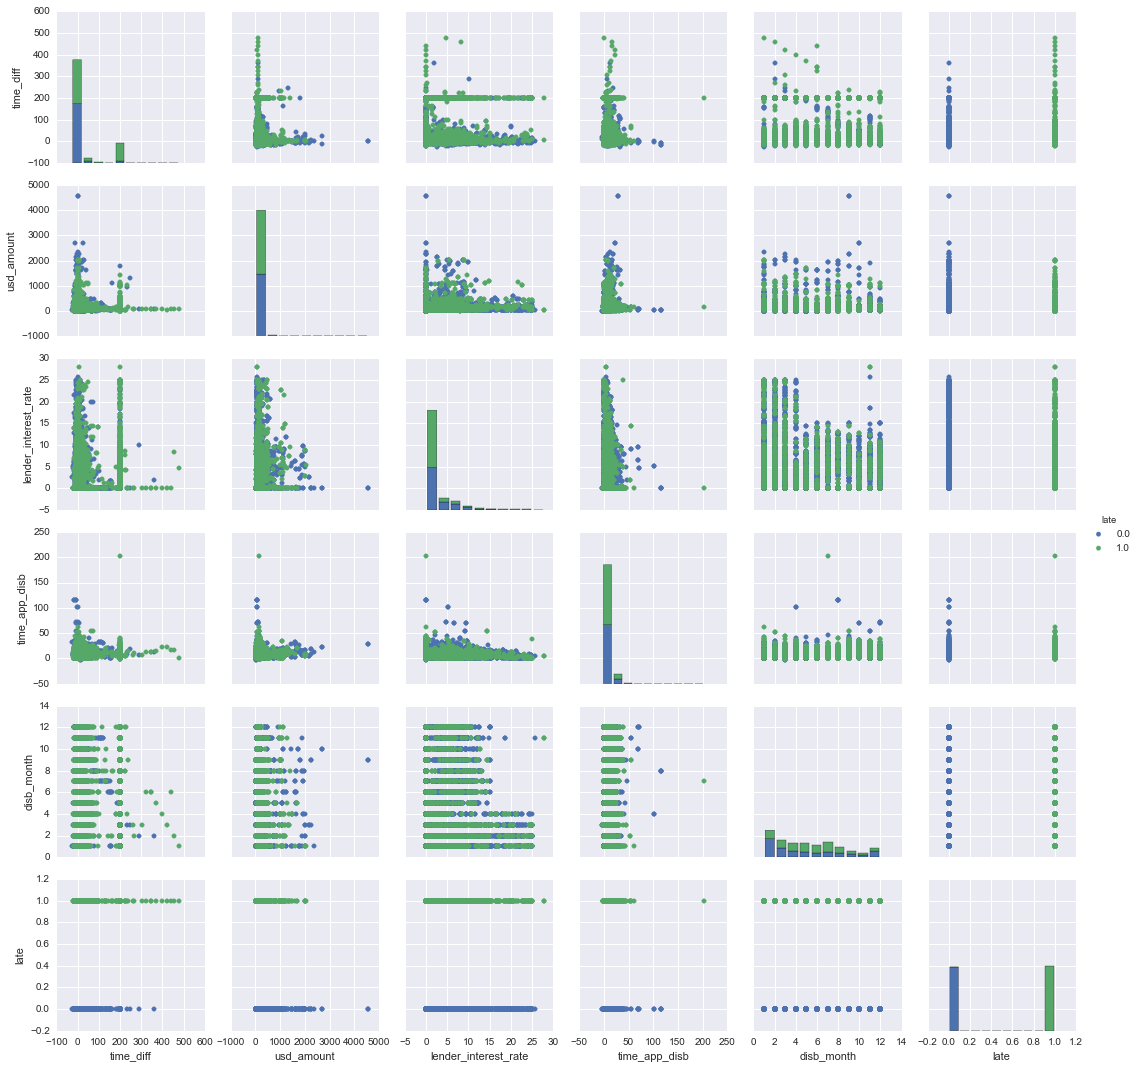

In [16]:
PAIRPLOTS FOR FIRST LOAN

g = sns.PairGrid(allFirstLoans_forpairplot, hue= 'late')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

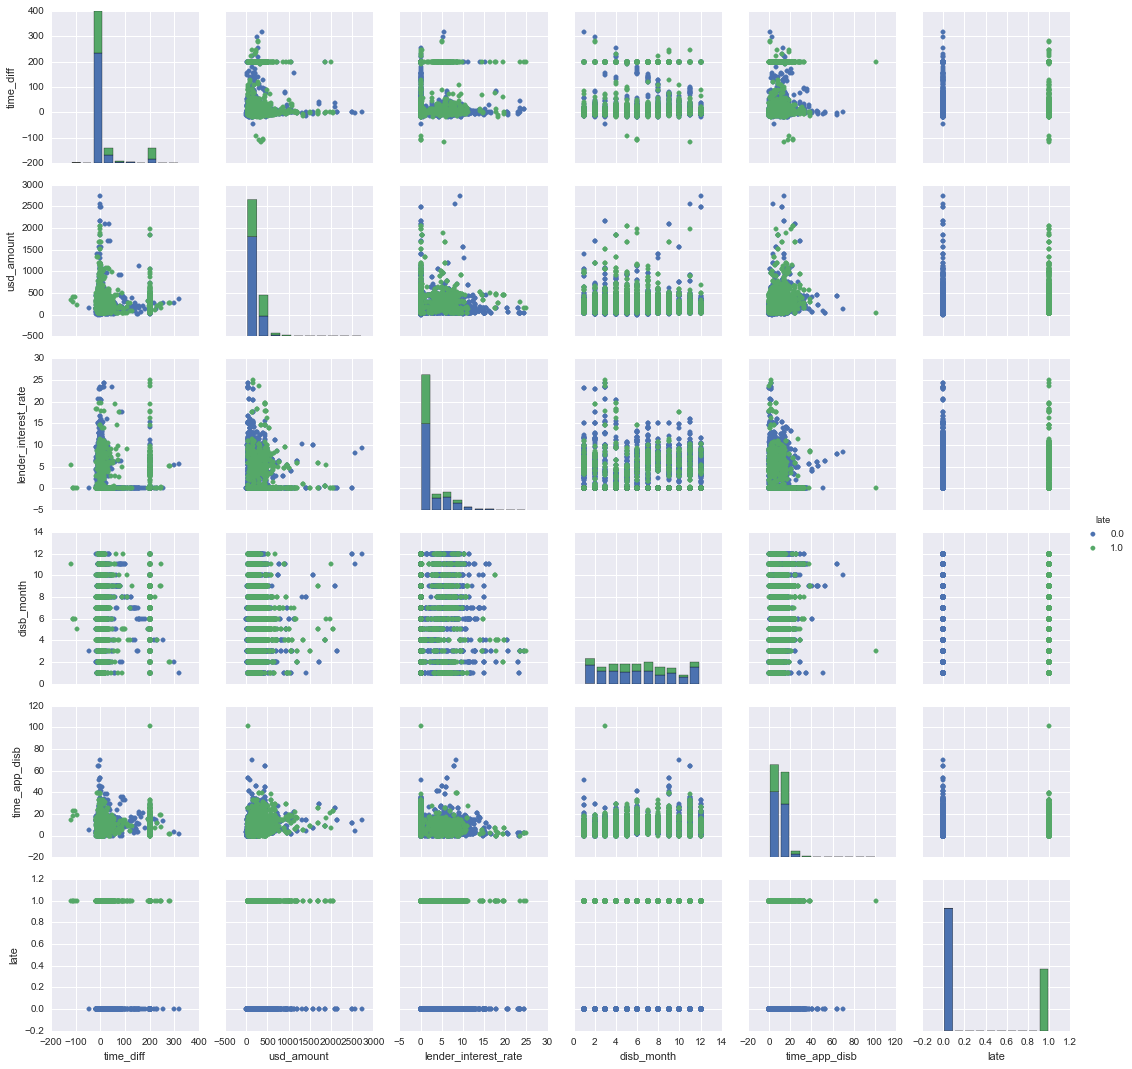

In [17]:

# Pairplots for SECOND LOAN

# set time_diff = 200 days for loans where time_diff = NaN (because they were never paid)
mlbsl_labeled.time_diff.fillna(200, inplace=True)
# fill lender_interest_rate to zero in absence of other information
mlbsl_labeled.lender_interest_rate.fillna(0, inplace = True)


g = sns.PairGrid(mlbsl_labeled[['time_diff', 'usd_amount', 'lender_interest_rate', 'disb_month','time_app_disb',  'late']], hue= 'late')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

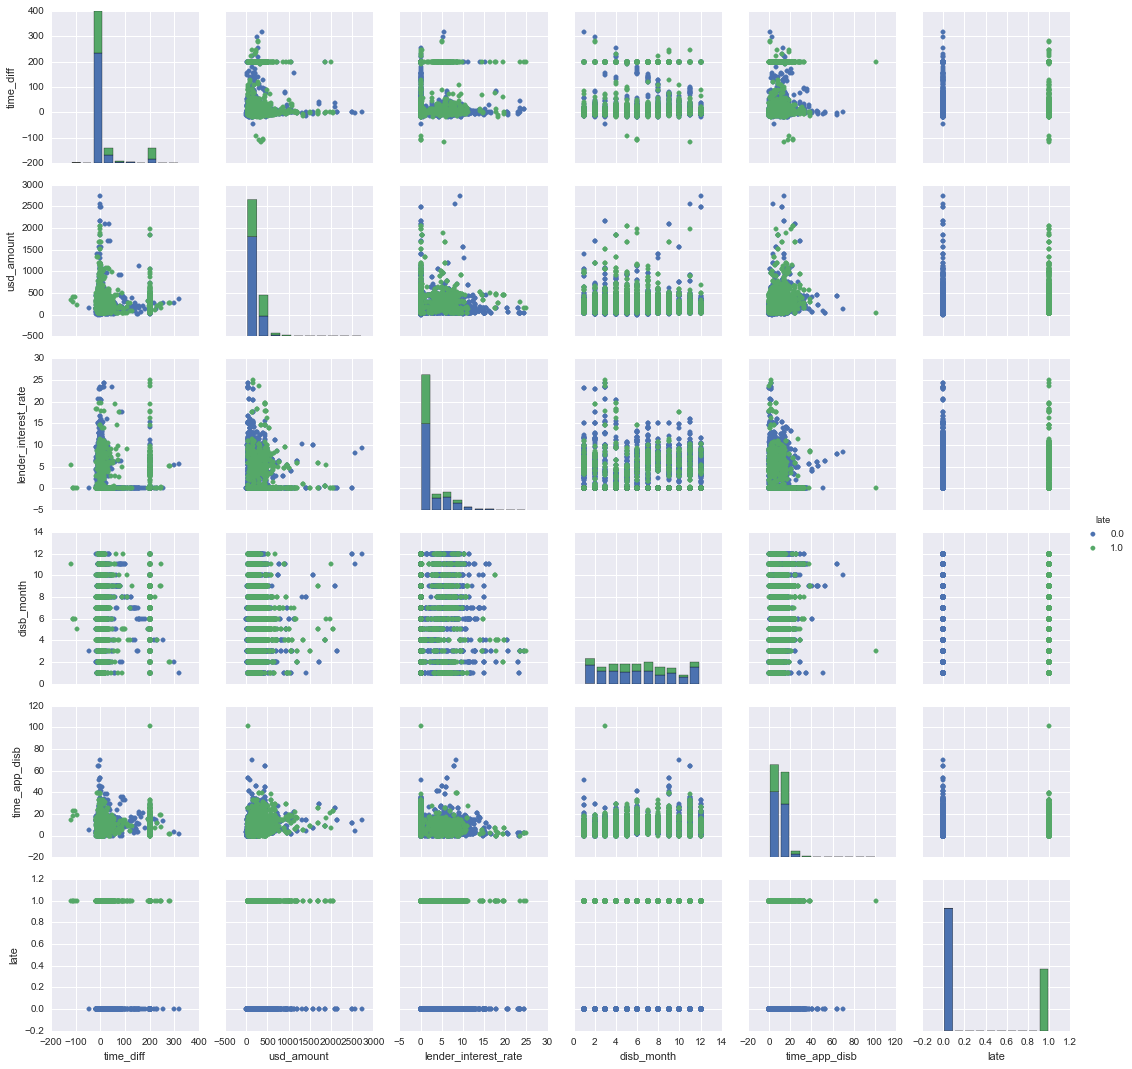

In [18]:
# PAIRPLOTS FOR THIRD LOAN

# set time_diff = 200 days for loans where time_diff = NaN (because they were never paid)
mlbtl_labeled.time_diff.fillna(200, inplace=True)
# fill lender_interest_rate to zero in absence of other information
mlbtl_labeled.lender_interest_rate.fillna(0, inplace = True)


g = sns.PairGrid(mlbsl_labeled[['time_diff', 'usd_amount', 'lender_interest_rate', 'disb_month','time_app_disb',  'late']], hue= 'late')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [ ]:
# FIRST LOAN, with labeles (late/not late) from the SECOND LOAN

In [19]:
firstLoan_secondLabel = pd.read_csv('proposal_numericInfo_loan1characteristics_loan2label.csv')

In [20]:
firstLoan_secondLabel.drop('Unnamed: 0', axis = 1, inplace = True)
firstLoan_secondLabel.head(2)

,borrower_id,proposal_x,proposal_y,late,loan_amt,td_median,td_std,td_skew,td_kurt,paid_diff_std,loan_ratio,disbursed_month_y,time_diff_acc_disb_y,applied_time_diff,prop_len_rat
0,32768,Dear lenders first for all is to thank the Zid...,My second loan i intend to use it by....\r\n1....,0,78,0,2.110579,-2.84605,6.1,0,1.871795,7,0,87,0.838137
1,32774,If and when my loan is fully funded i will be ...,when and if my loan project is fully funded i ...,0,100,0,0.000000,0.00000,-3.0,0,1.870000,5,0,51,0.887805


In [21]:
# Add more data (features) for larger pairplot

firstLoan_mergefeatures = pd.merge(firstLoan_secondLabel, allFirstLoans, how = 'inner', on = 'borrower_id')

In [22]:
firstLoan_mergefeatures.to_csv('firstLoan_labelsFromSecondLoan.csv')

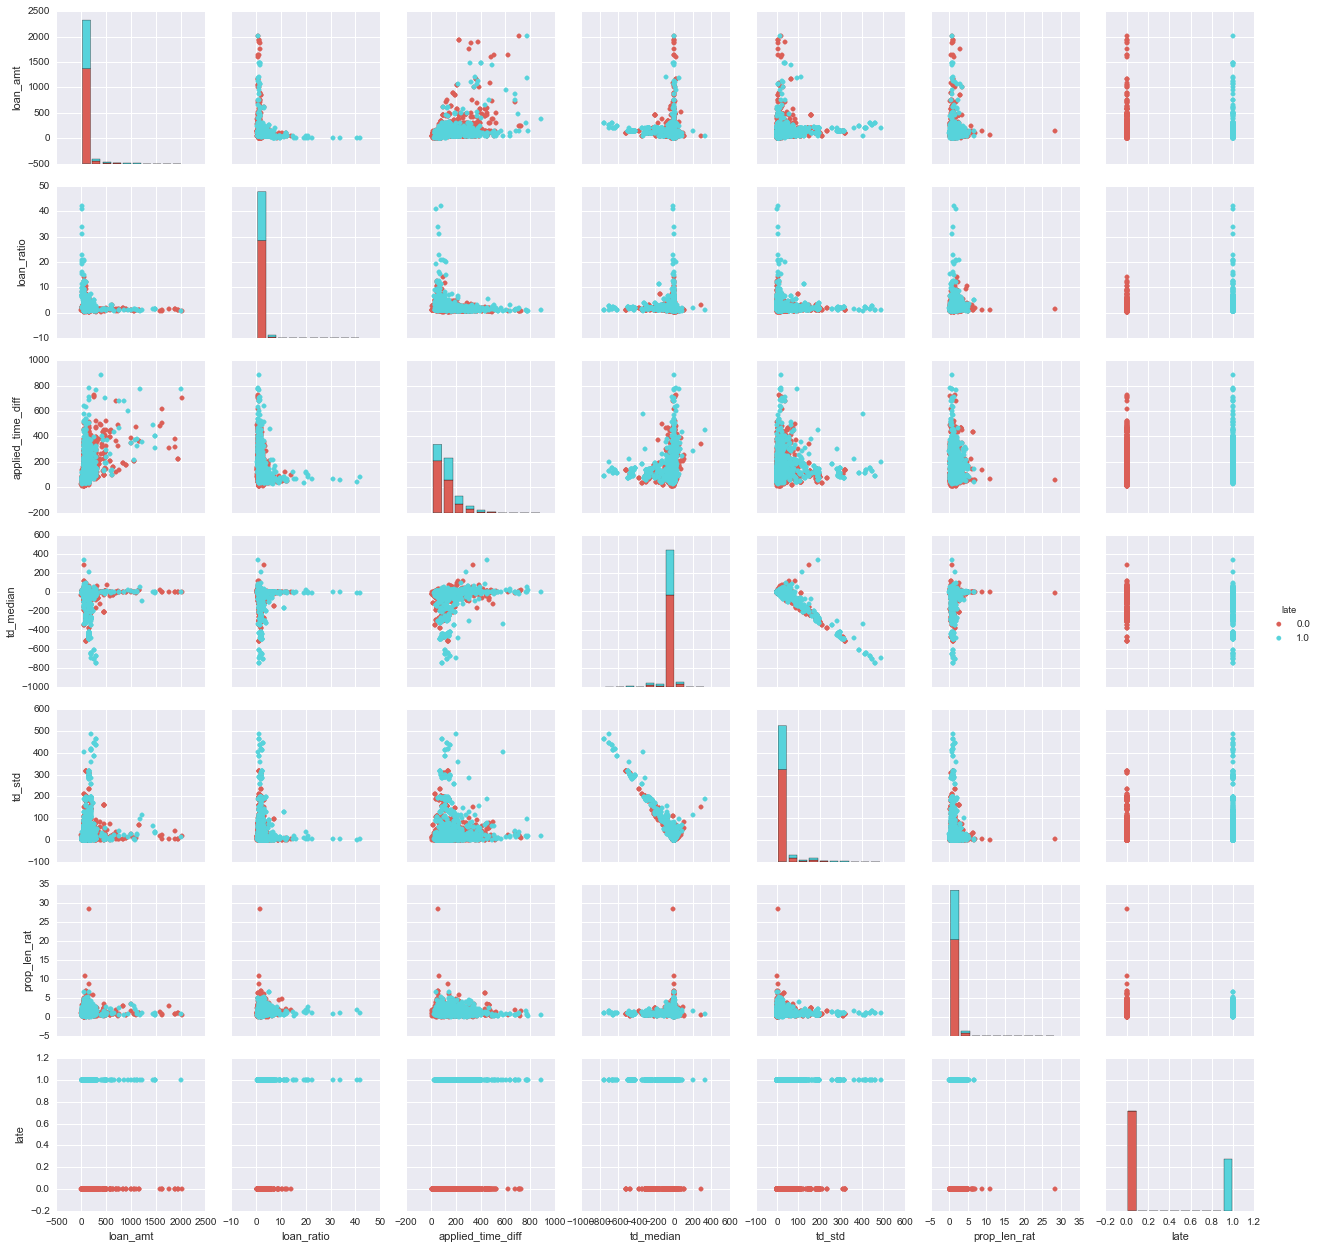

In [23]:
forPlot = firstLoan_secondLabel[['loan_amt','loan_ratio', 'applied_time_diff', 'td_median', 'td_std', 'prop_len_rat', 'late']]
g = sns.PairGrid(forPlot, hue= 'late', palette="hls")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

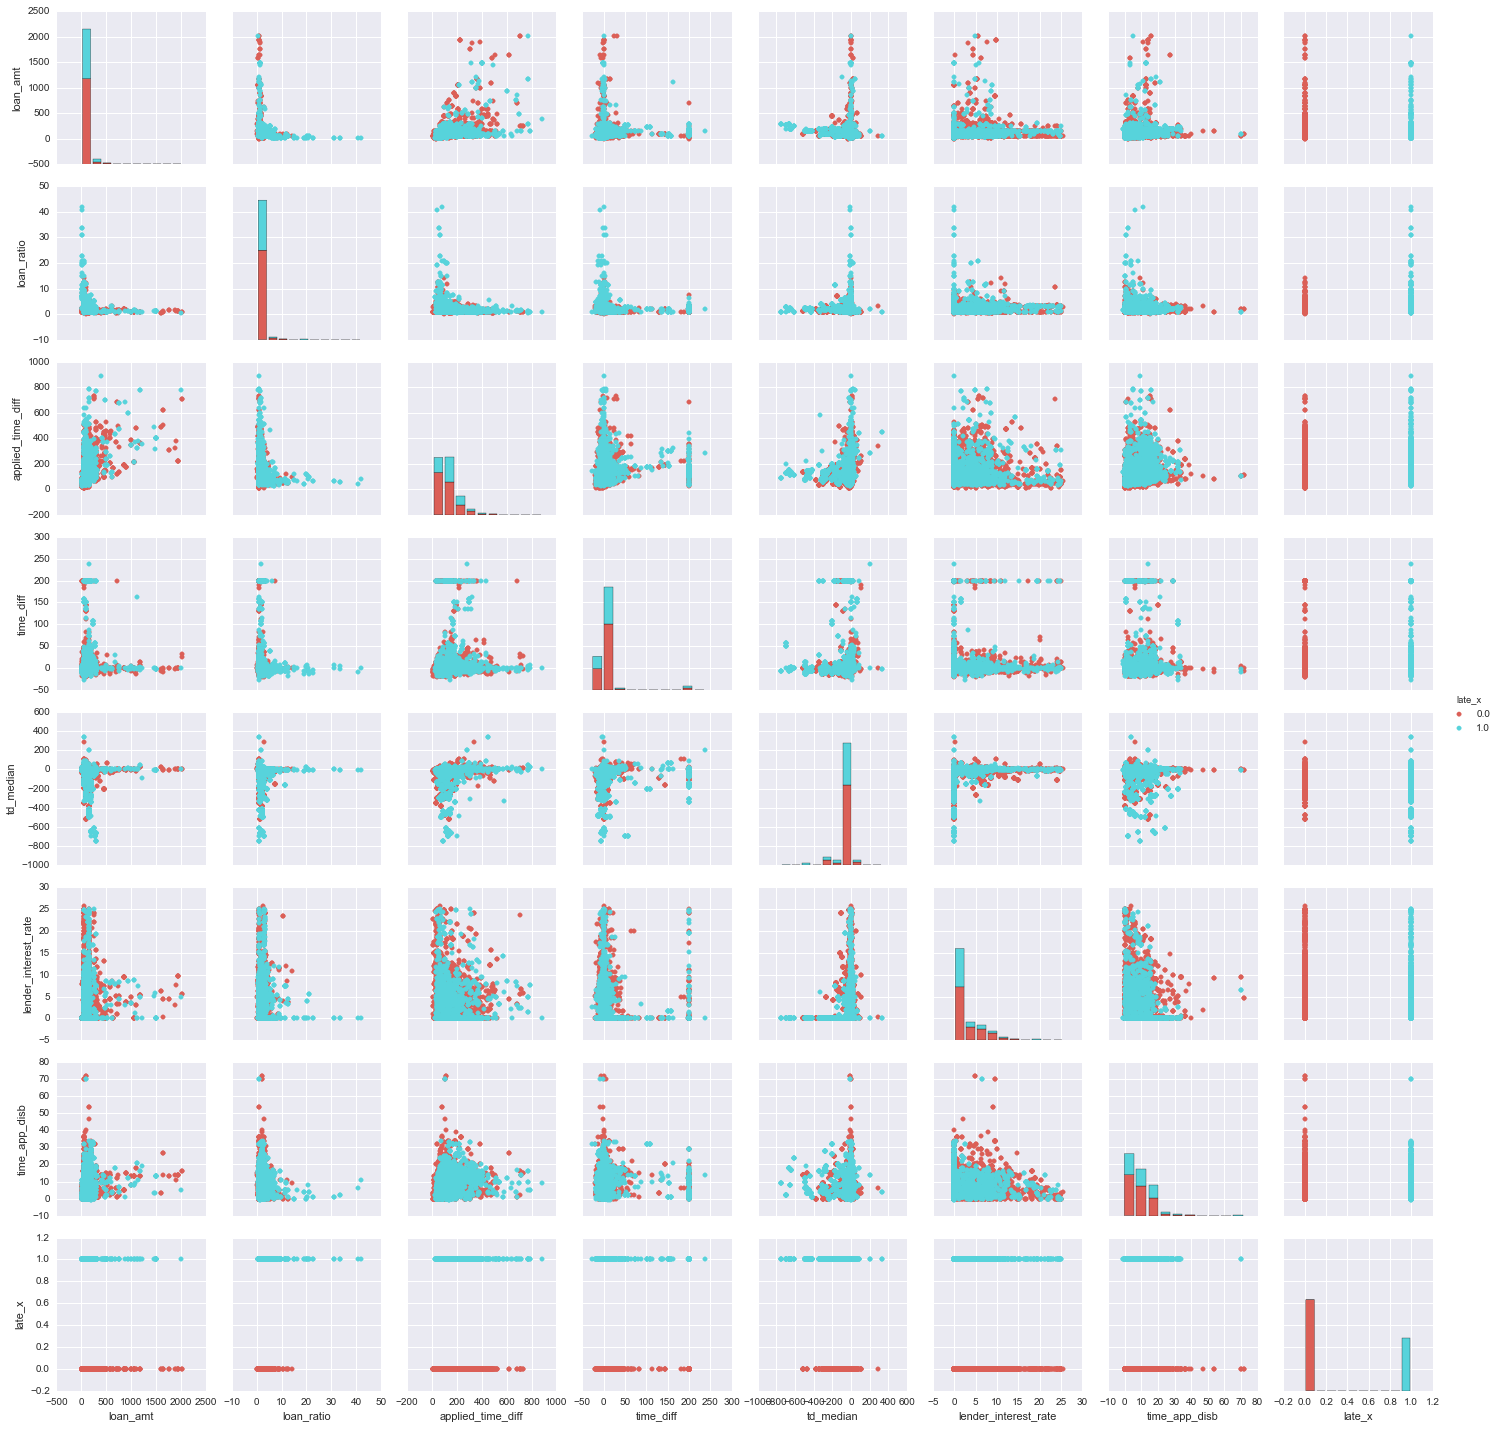

In [24]:
# Select certain features for pairplot

forPlot2 = firstLoan_mergefeatures[['loan_amt','loan_ratio', 'applied_time_diff', 'time_diff', 'td_median', 'lender_interest_rate','time_app_disb', 'late_x']]

g = sns.PairGrid(forPlot2, hue= 'late_x', palette="hls")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [25]:
firstLoan_mergefeatures.head(2)

,borrower_id,proposal_x,proposal_y,late_x,loan_amt,td_median,td_std,td_skew,td_kurt,paid_diff_std,...,loan_id,time_diff,usd_amount,lender_interest_rate,time_app_disb,appl_month,disb_month,applied_at,currency_code,late_y
0,32768,Dear lenders first for all is to thank the Zid...,My second loan i intend to use it by....\r\n1....,0,78,0,2.110579,-2.84605,6.1,0,...,16330,0,78,0,11,4,4,2015-04-11,KES,0
1,32774,If and when my loan is fully funded i will be ...,when and if my loan project is fully funded i ...,0,100,0,0.000000,0.00000,-3.0,0,...,15006,0,100,0,12,3,3,2015-03-08,GHS,0


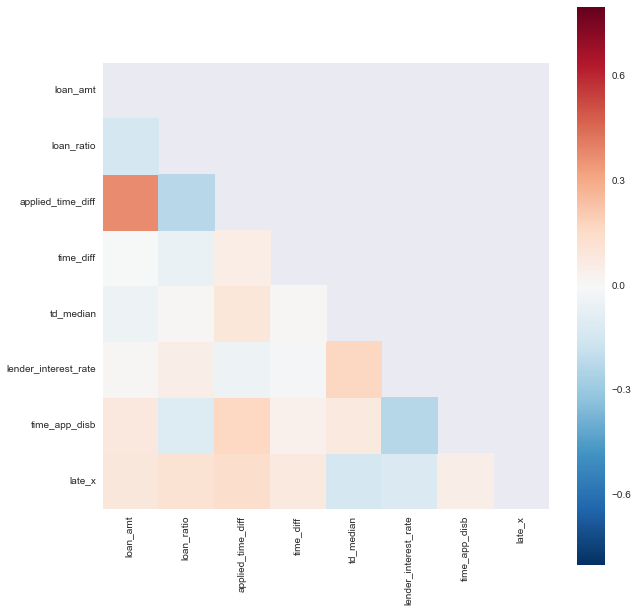

In [26]:
# Sanity check:
# Correlation between different parameters

# Compute the correlation matrix
corr = forPlot2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap using seaborn
sns.heatmap(corr, mask = mask, vmax=.8, square=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
           # square=True, xticklabels=2, yticklabels=2,
           # linewidths=.5,cbar_kws={"shrink": .75}, ax=ax)

In [20]:
bestFeatures = firstLoan_mergefeatures[['loan_amt','loan_ratio', 'applied_time_diff',  'lender_interest_rate','td_std', 'late_x']]

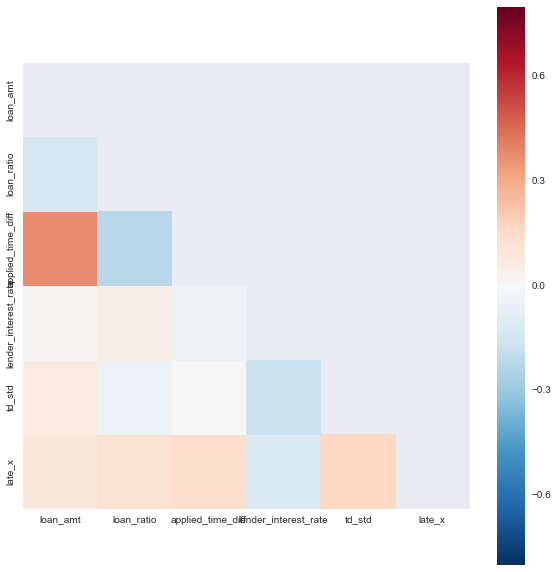

In [21]:
# Compute the correlation matrix
corr = bestFeatures.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap using seaborn
sns.heatmap(corr, mask = mask, vmax=.8, square=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
           # square=True, xticklabels=2, yticklabels=2,
           # linewidths=.5,cbar_kws={"shrink": .75}, ax=ax)

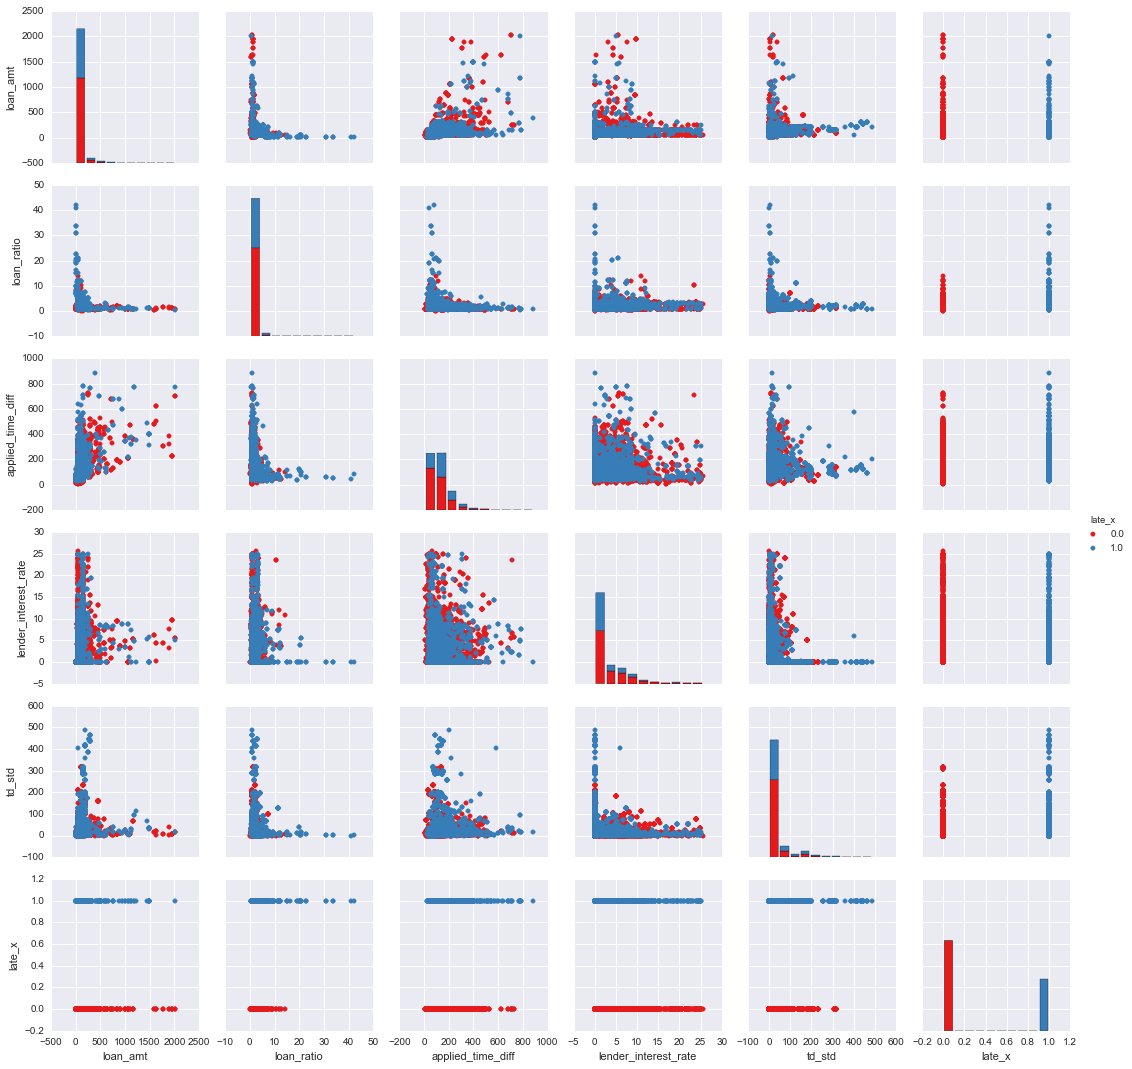

In [23]:
# Plot of best (most important) features for classification

g = sns.PairGrid(bestFeatures, hue= 'late_x', palette="Set1")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

0.0
1.0


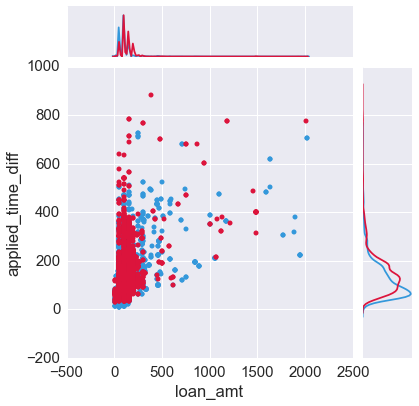

In [57]:
sns.set(font_scale=1.5)

df = firstLoan_mergefeatures
colors = ["#3498db", "#DC143C"]
g = sns.JointGrid("loan_amt", "applied_time_diff", df)
for lateness, grouped_df in df.groupby("late_x"):
    sns.kdeplot(grouped_df["loan_amt"], ax=g.ax_marg_x, color = colors[int(lateness)], legend=False)
    sns.kdeplot(grouped_df["applied_time_diff"], ax=g.ax_marg_y, vertical=True, color = colors[int(lateness)], legend=False)
    g.ax_joint.plot(grouped_df["loan_amt"], grouped_df["applied_time_diff"], "o", color = colors[int(lateness)], ms=5)
    print lateness

#sns.jointplot("loan_amt", "applied_time_diff", data= firstLoan_mergefeatures[firstLoan_mergefeatures.late_x == 1] , size=5, ratio=3, color="r", ax = ax)
#sns.jointplot("loan_amt", "applied_time_diff", data= firstLoan_mergefeatures[firstLoan_mergefeatures.late_x == 0] , size=5, ratio=3, color="b", ax = ax)